In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import pandas as pd
%config InlineBackend.figure_format = 'retina'

In [ ]:
import scanpy as sc

# Single cell transcriptional and chromatin accessibility profiling 
#  redefine cellular heterogeneity in the adult human kidney
rna_adata = sc.read('./data/rna/local.h5ad')
rna_adata.raw = rna_adata
rna_var = rna_adata.var.copy()

sc.pp.normalize_total(rna_adata)

sc.tl.rank_genes_groups(rna_adata,groupby='cell_type',method='wilcoxon', use_raw=False)

print(rna_adata.shape)

rna = rna_adata.to_df().groupby(rna_adata.obs['cell_type']).mean().T 
rna_unnormed = rna.copy()

rna += 1 / rna.shape[0] # pseudocount
rna.values[:] = rna.values / rna.values.sum(1,keepdims=True)

rna.shape

(19985, 33234)


(33234, 13)

In [ ]:
hpa_mapping = pd.Series({
    'epithelial cell of proximal tubule':'proximal tubule',
    'fibroblast':None,
    'glomerular visceral epithelial cell':'glomerulus',
    'kidney capillary endothelial cell':'glomerulus',
    'kidney connecting tubule epithelial cell':'distal tubule',
    'kidney distal convoluted tubule epithelial cell':'distal tubule',
    'kidney loop of Henle thick ascending limb epithelial cell':'distal tubule',
    'leukocyte':None,
    'mesangial cell':'glomerulus',
    'parietal epithelial cell':'glomerulus',
    'renal alpha-intercalated cell':'collecting duct',
    'renal beta-intercalated cell':'collecting duct',
    'renal principal cell':'collecting duct'
},name='region')

hpa_markers = pd.read_csv('hpa_markers.csv',comment='#')
gene_symbols = pd.read_table('gene_symbols.tsv').iloc[:,[0,-1]]
hpa_markers = hpa_markers.merge(gene_symbols,left_on='gene',right_on='Approved symbol',how='inner')
hpa_markers = hpa_markers.set_index(hpa_markers.columns[-1])[['region','gene']]
hpa_markers

region     gene
Ensembl ID(supplied by Ensembl)                          
ENSG00000128567                       glomerulus    PODXL
ENSG00000158457                       glomerulus  TSPAN33
ENSG00000113578                       glomerulus     FGF1
ENSG00000116218                       glomerulus    NPHS2
ENSG00000198743                       glomerulus   SLC5A3
...                                          ...      ...
ENSG00000105707                  collecting duct      HPN
ENSG00000214128                  collecting duct  TMEM213
ENSG00000100362                  collecting duct    PVALB
ENSG00000132677                  collecting duct     RHBG
ENSG00000113073                  collecting duct   SLC4A9

[137 rows x 2 columns]

In [ ]:
df = pd.read_pickle('./data/HPAv21/proteinatlas.pkl').set_index('Image')
df['duplicated'] = df.index.value_counts()[df.index] > 1

# I think it's totally fair to do this ... ?
df_test = df.copy() #query('(Staining=="high")|(Staining=="medium")')
test_set = list(df_test.index.unique())

df_train = df.query('(Staining=="high")|(Staining=="medium")').query('Reliability=="Enhanced"').query('~duplicated')
# df_train = df_filtered.query('(Staining=="high")').query('Reliability=="Enhanced"')
train_set = list(df_train.index.unique())

len(df_test), len(df_train)

(66138, 10164)

In [ ]:
df_train['Gene'].nunique()

2106

In [14]:
# moco would prob be better, i'm having ram problems
from ContrastiveEmbedding import *
hparams = {
    'embedding_dim':128, # *imagenet* with 1k classes uses 128d
    'patch_size':256, # doubling uses too much vram
    'image_size':512,
    'batch_size':150, #224
    'temperature':1.0,
    'learning_rate':5e-4,
    'weight_decay':0,
#     'data_dir':'./data/kidney512',
    'data_dir':'./data/HPAv21/kidney_images',
    'cache_dir':'$TMPDIR/kidney_images',
    'name_field':'Image',
    'filter_by':{'Image':train_set},
#     'group_by':'Gene', # gene grouping looks amazing w/ 'enhanced'
    'group_by':'Image', # gene grouping looks amazing w/ 'enhanced'
    'train_cnn':True,
    'attention':False,
    'importance':True,
    'color_transfer':False,
    'augment':True,
    'random_init':False,
    'scramble':True
    #'warm_start':'./logs/ContrastiveEmbedding/default/clf_only/checkpoints/epoch=29-step=116.ckpt'
}
dm = JSONImageDataModule(**hparams)
# ^^^ there's some real crap in here that breaks encapsulation horribly
# hard-coding the directory structure, transforms, filtering / grouping criteria
# -> I want a database of images on the MIT intranet that permits this sort of SQL query 
# see 'smart_open'
# and a a dataloader that doesn't have a race condition (I tihnk its Albumentations)
model = ContrastiveEmbedding(**hparams)

In [15]:
# import sys
# sys.path.insert(1, '../ClusterTools')
# from ClusterTools import *

# Cluster(
#     gpus=1,
#     cpus=20,
#     num_nodes=4, # not enough batches for 8 with gene grouping?
#     version='redownloaded_v2_scrambled',
#     log_dir='./logs/ContrastiveEmbedding',
#     ddp_args={ # should bake these into the datamodule
# #         'find_unused_parameters':False,
# #         'replace_sampler_ddp':False
#     }
# ).train(
#     model, 
#     dm,
#     min_epochs=188,
#     max_epochs=188,
#     log_every_n_steps=5,
#     precision=16,
#     train_async=True
# );

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
mkdir: cannot create directory '/state/partition1/slurm_tmp/12729928.0.0/kidney_images': File exists
Set SLURM handle signals.

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 7.1 M 
1 | projection | Sequential | 33.0 K
2 | transform  | Sequential | 0     
------------------------------------------
7.1 M     Trainable params
0         Non-trainable params
7.1 M     Total params
28.472    Total estimated model params size (MB)


Submitted batch job 12733229


In [18]:
version = 'redownloaded_v2'

[last_ckpt] = !ls -t1 ./logs/ContrastiveEmbedding/default/{version}/checkpoints/*.ckpt | head -n1
print(last_ckpt)
model = ContrastiveEmbedding.load_from_checkpoint(last_ckpt)
hparams = model.hparams

hparams['name_field'] = 'Image'
hparams['filter_by'] = {'Image':test_set}

dm = JSONImageDataModule(**hparams)
dm.setup()

model.eval()
model.requires_grad_(False)
model = model.cuda()

./logs/ContrastiveEmbedding/default/redownloaded_v2/checkpoints/epoch=999-step=2997.ckpt


mkdir: cannot create directory '/state/partition1/slurm_tmp/12729928.0.0/kidney_images': File exists


In [21]:
# embeddings = {}

# for batch in tqdm(dm.test_dataloader()):
#     (x,data), = batch
#     name = data[hparams['name_field']]

# #     for i in range(x.shape[0]):
# #         x_i = x[i].flatten()
# #         x_i = x_i[torch.randperm(len(x_i))]
# #         x[i] = x_i.reshape(x[i].shape)
#     z = model.encoder(x.to(model.device)).cpu()
# #     z = model(x.to(model.device)).cpu()
#     for name_i, z_i in zip(name,z):
#         embeddings[name_i] = z_i.numpy()
        
# embeddings = pd.DataFrame(embeddings).T

# embeddings.to_pickle(f'./logs/ContrastiveEmbedding/default/{version}/embeddings.pkl')

# embeddings.shape

(61539, 128)

In [ ]:
embeddings = pd.read_pickle(f'./logs/ContrastiveEmbedding/default/{version}/embeddings.pkl')
embeddings.shape

In [11]:
# !cp ./logs/ContrastiveEmbedding/default/{version}/embeddings.pkl ./logs/ContrastiveEmbedding/default/{version}/embeddings_saved.pkl

In [22]:
import scanpy as sc

adata = embeddings.join(df)
adata = sc.AnnData(adata[embeddings.columns], obs=adata[df.columns])

adata.obs = adata.obs.join(rna,on='Gene',how='left')
adata.obs['Patient'] = adata.obs['Patient'].astype('str').str.rstrip('.0')
adata.obs.columns = adata.obs.columns.astype(str)
adata.obs['cell_type'] = adata.obs[rna.columns].idxmax(1)
adata.obs['specificity'] = adata.obs[rna.columns].max(1)

scl = pd.read_table('subcellular_location.tsv')
scl = scl.set_index('Gene')['Main location'].str.split(';',expand=True).melt(ignore_index=False)
scl = scl.groupby('Gene')['value'].value_counts().unstack(fill_value=0)
adata.obs = adata.obs.join(scl,on='Gene',how='left')

adata_train = adata[adata.obs_names.isin(train_set)].copy()
adata_test = adata[adata.obs_names.isin(test_set)].copy()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [23]:
sc.pp.neighbors(adata_train,use_rep='X')
sc.tl.umap(adata_train, min_dist=0.5)

... storing 'Batch' as categorical
... storing 'Well' as categorical
... storing 'Tissue' as categorical
... storing 'Gene name' as categorical
... storing 'Gene' as categorical
... storing 'UniProt' as categorical
... storing 'Antibody' as categorical
... storing 'Staining' as categorical
... storing 'Sex' as categorical
... storing 'Patient' as categorical
... storing 'Level' as categorical
... storing 'Reliability' as categorical


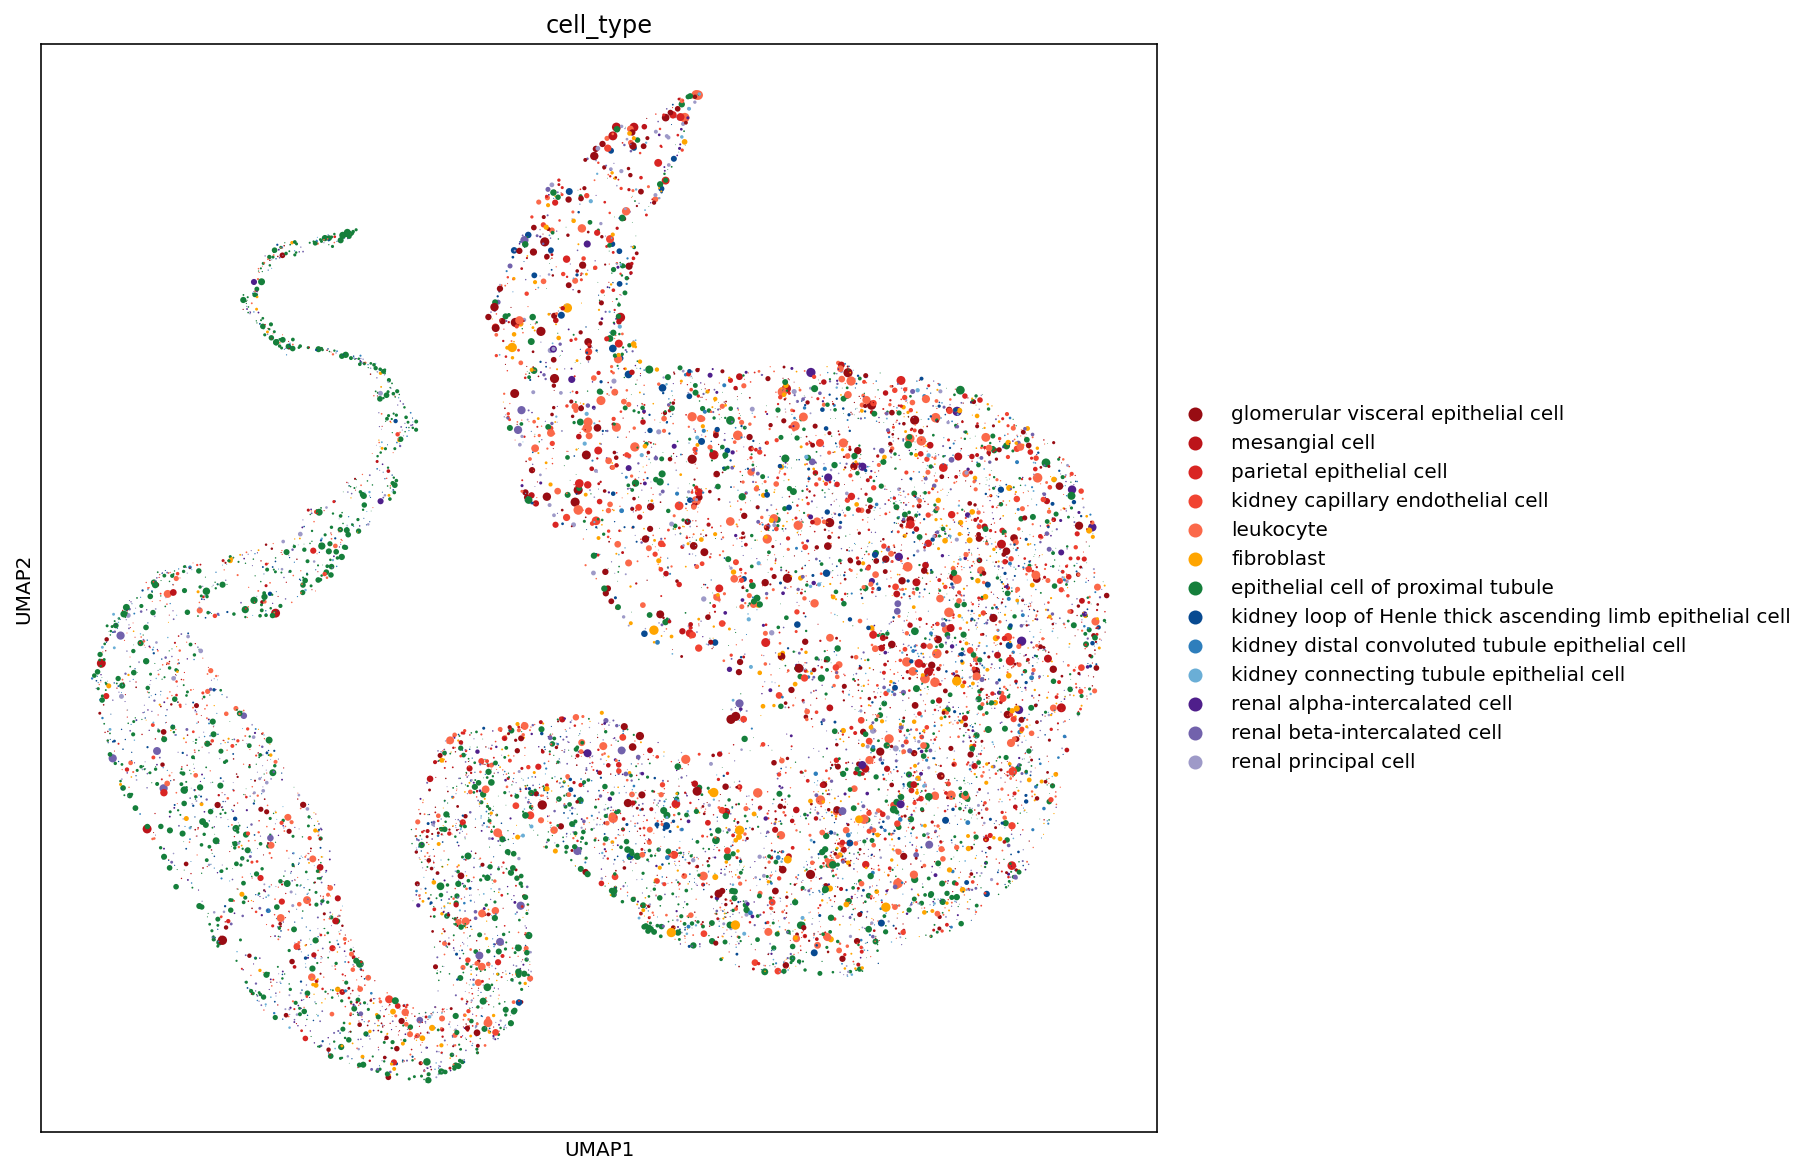

In [24]:
cell_type_colors = {
    'glomerular visceral epithelial cell':plt.get_cmap('Reds')(0.9),
    'mesangial cell':plt.get_cmap('Reds')(0.8),
    'parietal epithelial cell':plt.get_cmap('Reds')(0.7),
    'kidney capillary endothelial cell':plt.get_cmap('Reds')(0.6),
    'leukocyte':plt.get_cmap('Reds')(0.5),
    #
    'fibroblast':'orange',
    #
    'epithelial cell of proximal tubule':plt.get_cmap('Greens')(0.8),
    #
    'kidney loop of Henle thick ascending limb epithelial cell':plt.get_cmap('Blues')(0.9),
    'kidney distal convoluted tubule epithelial cell':plt.get_cmap('Blues')(0.7),
    'kidney connecting tubule epithelial cell':plt.get_cmap('Blues')(0.5),
    #
    'renal alpha-intercalated cell':plt.get_cmap('Purples')(0.9),
    'renal beta-intercalated cell':plt.get_cmap('Purples')(0.7),
    'renal principal cell':plt.get_cmap('Purples')(0.5),
}

fig, ax = plt.subplots(figsize=(10,10))
adata_train.obs['cell_type'] = adata_train.obs['cell_type'].astype('category').cat.reorder_categories(list(cell_type_colors))
sc.pl.umap(
    adata_train, 
    color=['cell_type'], 
    palette=cell_type_colors, 
    ax=ax, 
    s=adata_train.obs['specificity']**2*100,
#     s=(adata_train.obs['specificity']>0.5)*100,
    na_in_legend=False,
#     show=False
)
# for k,l in enumerate(adata_train.obs['leiden'].unique()):
#     points = adata_train.obsm['X_umap'][adata_train.obs['leiden']==l]
#     edges = alpha_shape(
#         points,
#         0.3
#     )
#     for i, j in edges:
#         ax.plot(points[[i, j], 0], points[[i, j], 1], c=adata_train.uns['leiden_colors'][k], alpha=0.5)

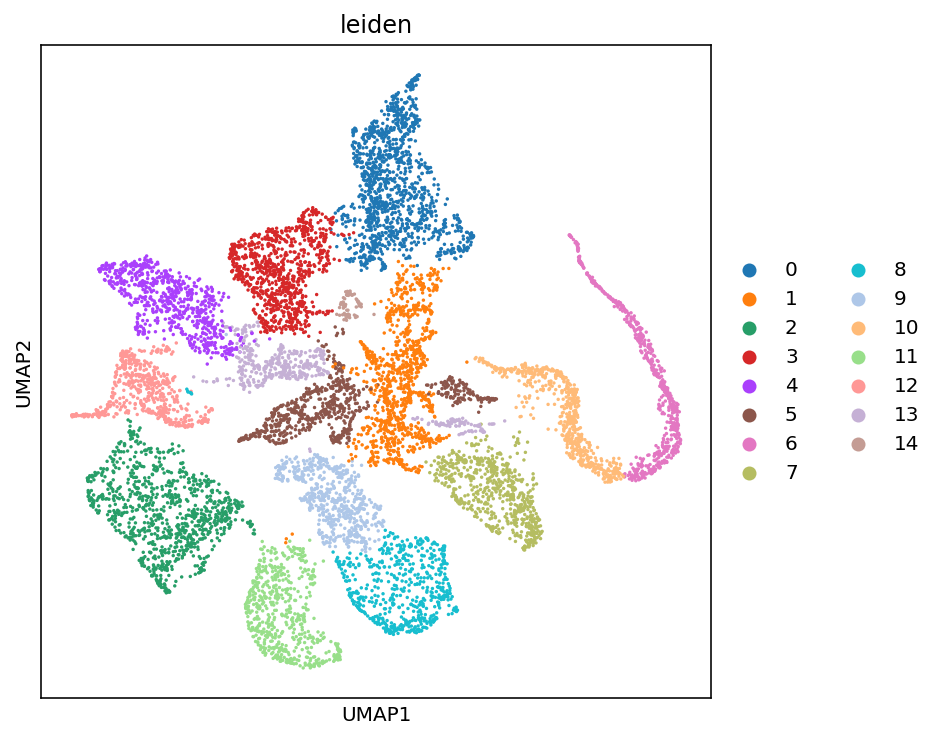

In [15]:
sc.tl.leiden(adata_train, resolution=0.25)
sc.pl.umap(adata_train,color='leiden',ax=plt.subplots(figsize=(6,6))[1])

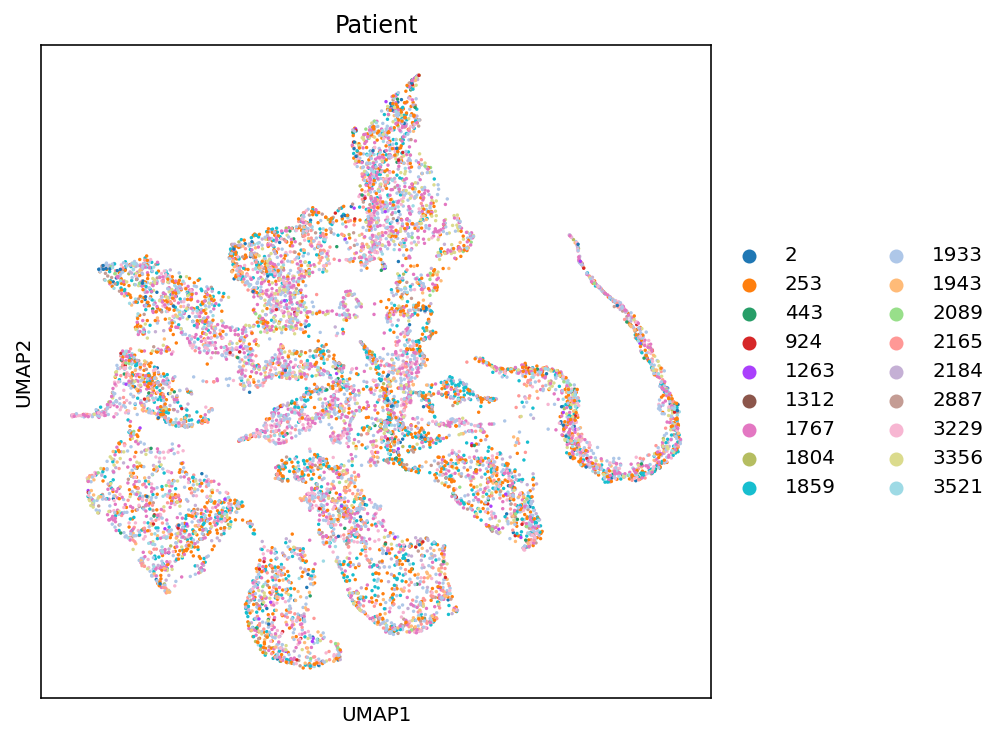

0.012156827491125703

In [16]:
sc.pl.umap(adata_train,color=['Patient'],ax=plt.subplots(figsize=(6,6))[1])
from sklearn.metrics import adjusted_mutual_info_score
adjusted_mutual_info_score(
    adata_train.obs['leiden'], 
    adata_train.obs['Patient']
)

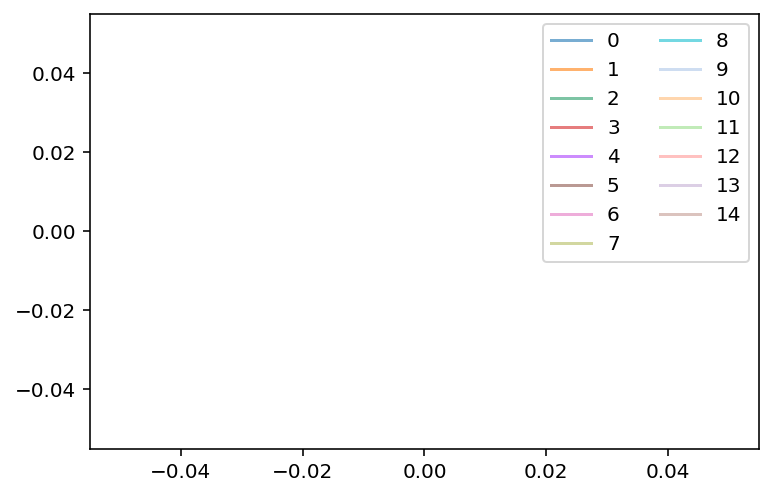

In [17]:
for i,c in enumerate(adata_train.uns['leiden_colors']):
    plt.plot([],[],c=c,label=i,alpha=0.6)
plt.legend(ncol=2)

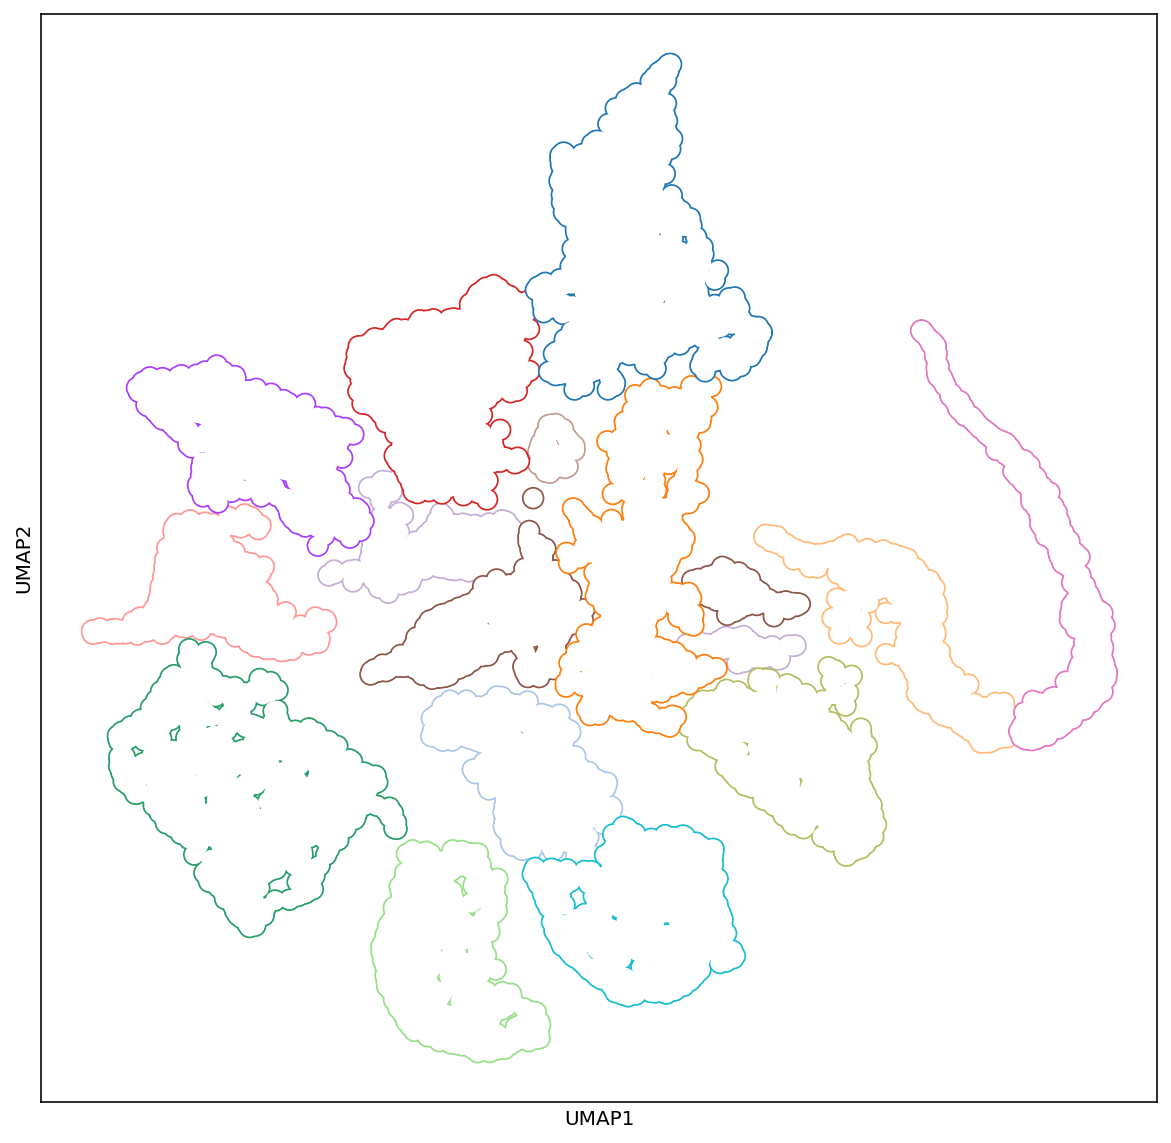

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
from sklearn.neighbors import kneighbors_graph
G = kneighbors_graph(adata_train.obsm['X_umap'],10)
is_artifact = np.zeros(len(adata_train),dtype=bool)
for i in range(len(is_artifact)):
    _, idx = G[i].nonzero()
    is_artifact[i] = sum(adata_train.obs['leiden'][idx] == adata_train.obs['leiden'][i]) < 8
for i,l in list(enumerate(adata_train.obs['leiden'].cat.categories))[::-1]:
    sc.pl.umap(adata_train, na_color='white', ax=ax, na_in_legend=False, show=False,
               add_outline=True, outline_color=(adata_train.uns['leiden_colors'][i],'white'),
               s=300*(adata_train.obs['leiden']==l)*(~is_artifact),
              outline_width=(0.1, 0.05))

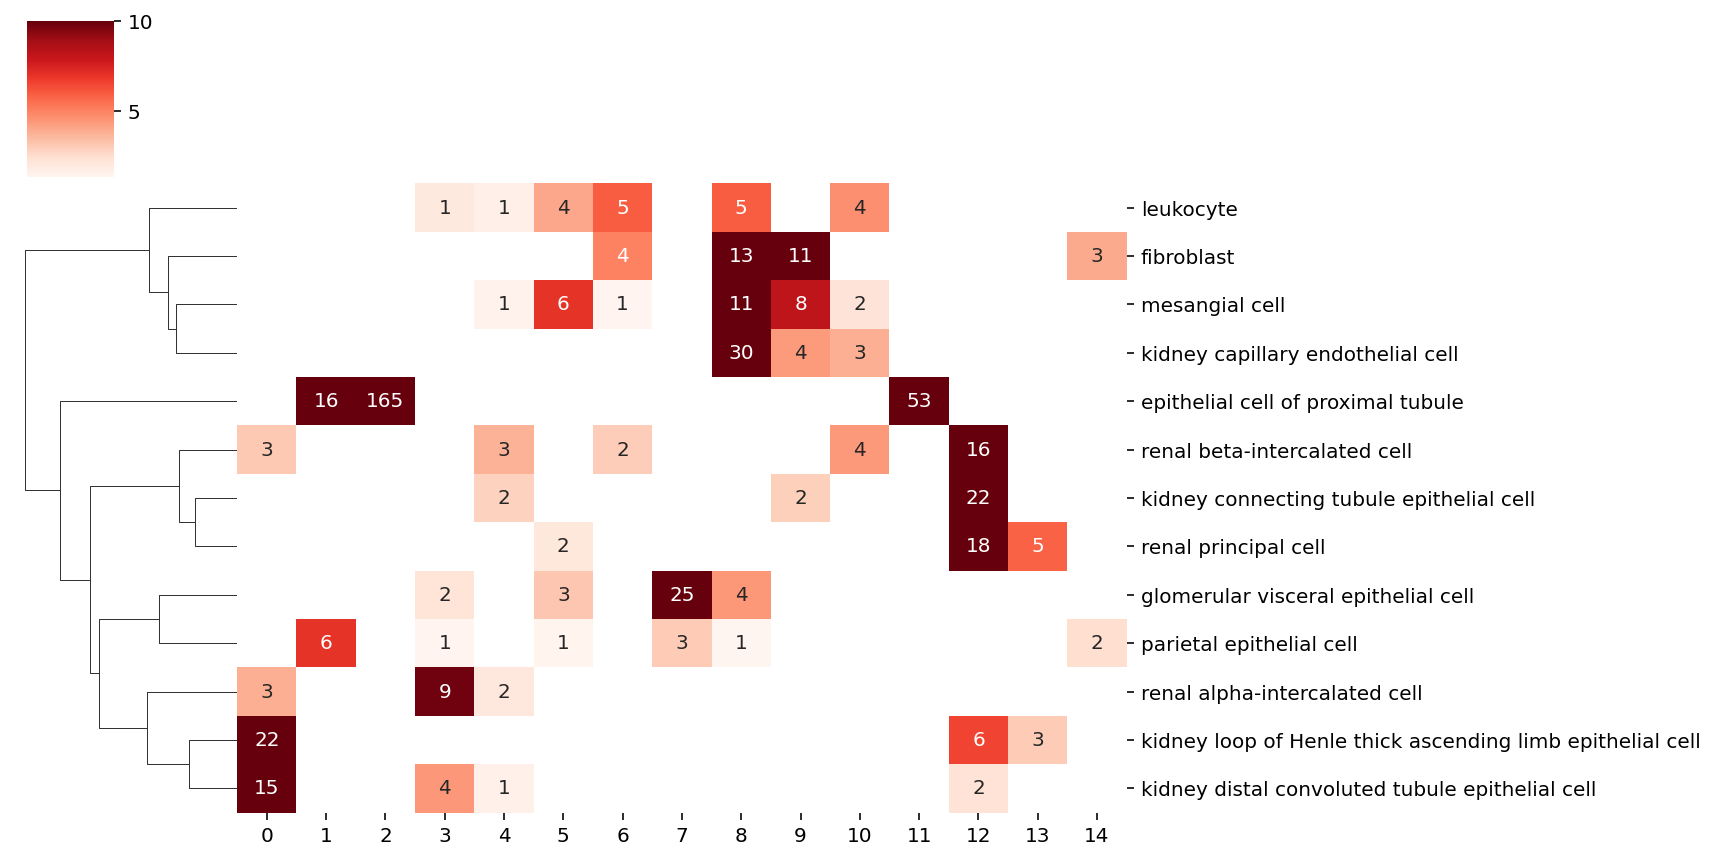

In [19]:
from sklearn.metrics.cluster import contingency_matrix
from scipy.stats import hypergeom
from statsmodels.stats.multitest import fdrcorrection

def hgtest(mtx):
    ks = mtx.copy()
    Ks = mtx.sum(0)
    ns = mtx.sum(1)
    N = mtx.sum().sum()
    
    pvals = mtx.copy() * np.nan

    for i in range(pvals.shape[0]):
        for j in range(pvals.shape[1]):
            k = ks.iloc[i,j]
            n = ns.iloc[i]
            K = Ks.iloc[j]
            pval = hypergeom.sf(k-1,N,n,K)
            pvals.iloc[i,j] = pval
            
#     pvals = pvals.dropna(axis=1)
#     for i in range(pvals.shape[0]):
#         pvals.values[i] = fdrcorrection(pvals.values[i])[1]

    return pvals

mtx = contingency_matrix(adata_train.obs['cell_type'].cat.codes,adata_train.obs['leiden'].cat.codes)
mtx = pd.DataFrame(mtx,
                   index=adata_train.obs['cell_type'].cat.categories,
                   columns=adata_train.obs['leiden'].cat.categories).T

pvals = hgtest(mtx)
x = (-np.log10(pvals)).T

sns.clustermap(x.clip(0,10),
               method='ward',
               col_cluster=False,
               cmap='Reds',
               mask=x<-np.log10(0.05),
               annot=np.floor(x),
               fmt='.0f',
               figsize=(12,6)
              )

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
 
y = adata_train.obs['leiden'].astype(int)
# lm = LogisticRegression(penalty='none')
lm = SVC(kernel='rbf',C=1.0,probability=True)
lm.fit(adata_train.X, y)
cluster_scores = pd.DataFrame(lm.predict_proba(adata_train.X),index=adata_train.obs_names)

cluster 2


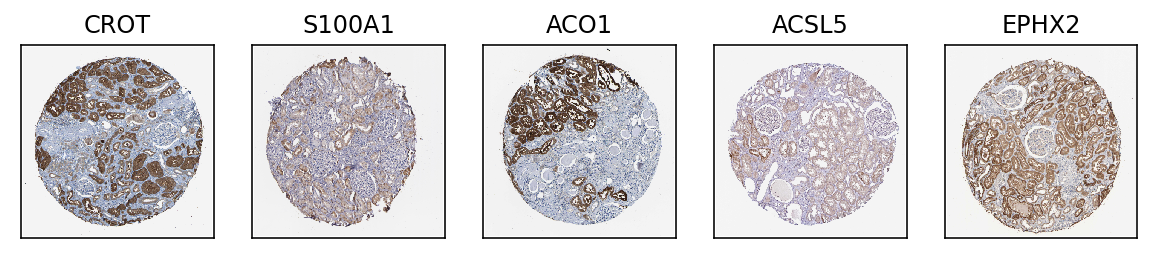

cluster 11


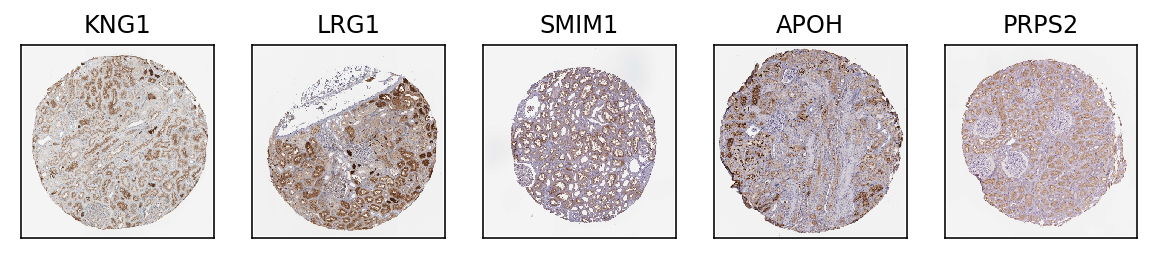

cluster 7


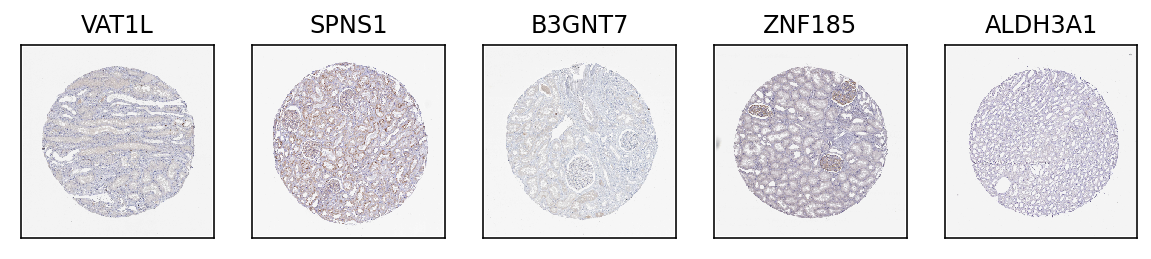

cluster 8


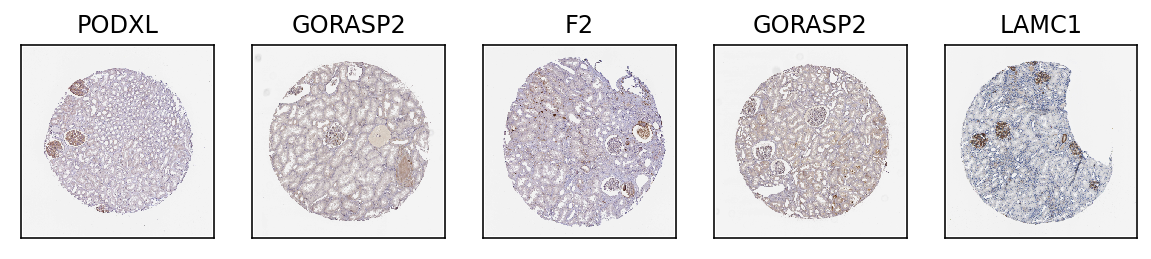

cluster 12


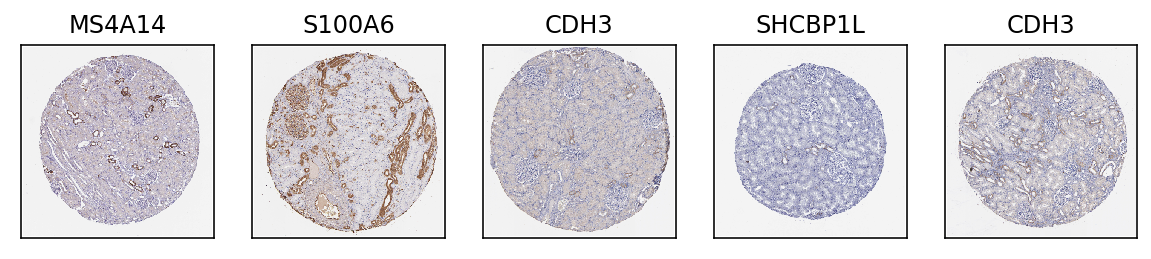

cluster 0


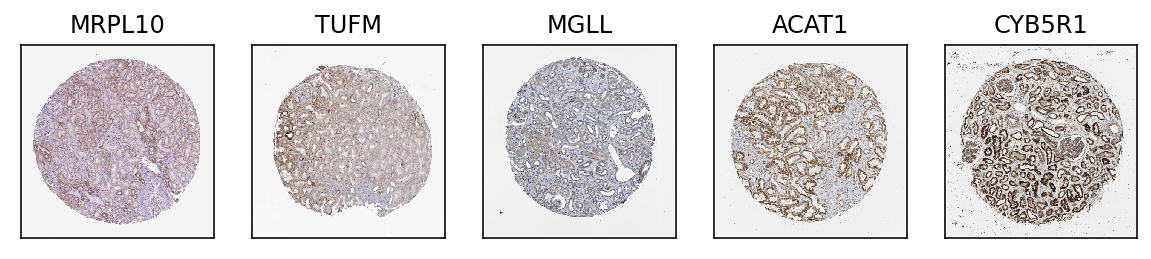

cluster 6


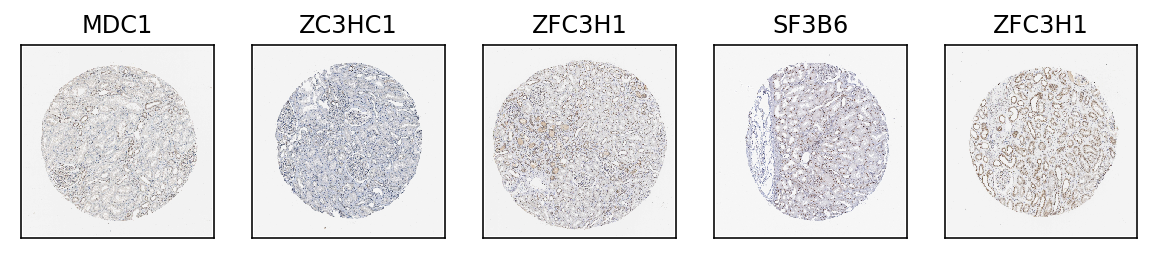

cluster 10


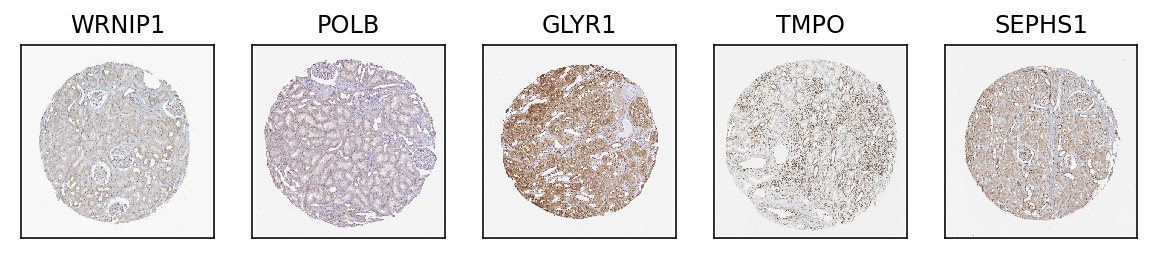

In [54]:
from imageio import imread

image_names = dict(zip(df.index,df['Gene name']))
gene_names = dict(zip(df.index,df['Gene']))
cell_types = rna.columns

for c in [2,11,7,8,12,0,6,10]:
    names = cluster_scores[c].sort_values(ascending=False).index.tolist()
#     npr.seed(0)
#     npr.shuffle(names)
    nfigs = 5
    names = names[:nfigs]
    print(f'cluster {c}')
    figsize=2
    fig,axs=plt.subplots(1,nfigs,figsize=(nfigs*figsize,figsize))
    axs=axs.ravel()
    for i, (name, path) in enumerate(zip(names,df.loc[names]['Filename'])):
        path = './data/HPAv21/kidney_images/'+path
        img = imread(path)
        axs[i].matshow(img)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(image_names[name])# + ' %.2f'%rna[c][gene_names[name]])
    plt.show()

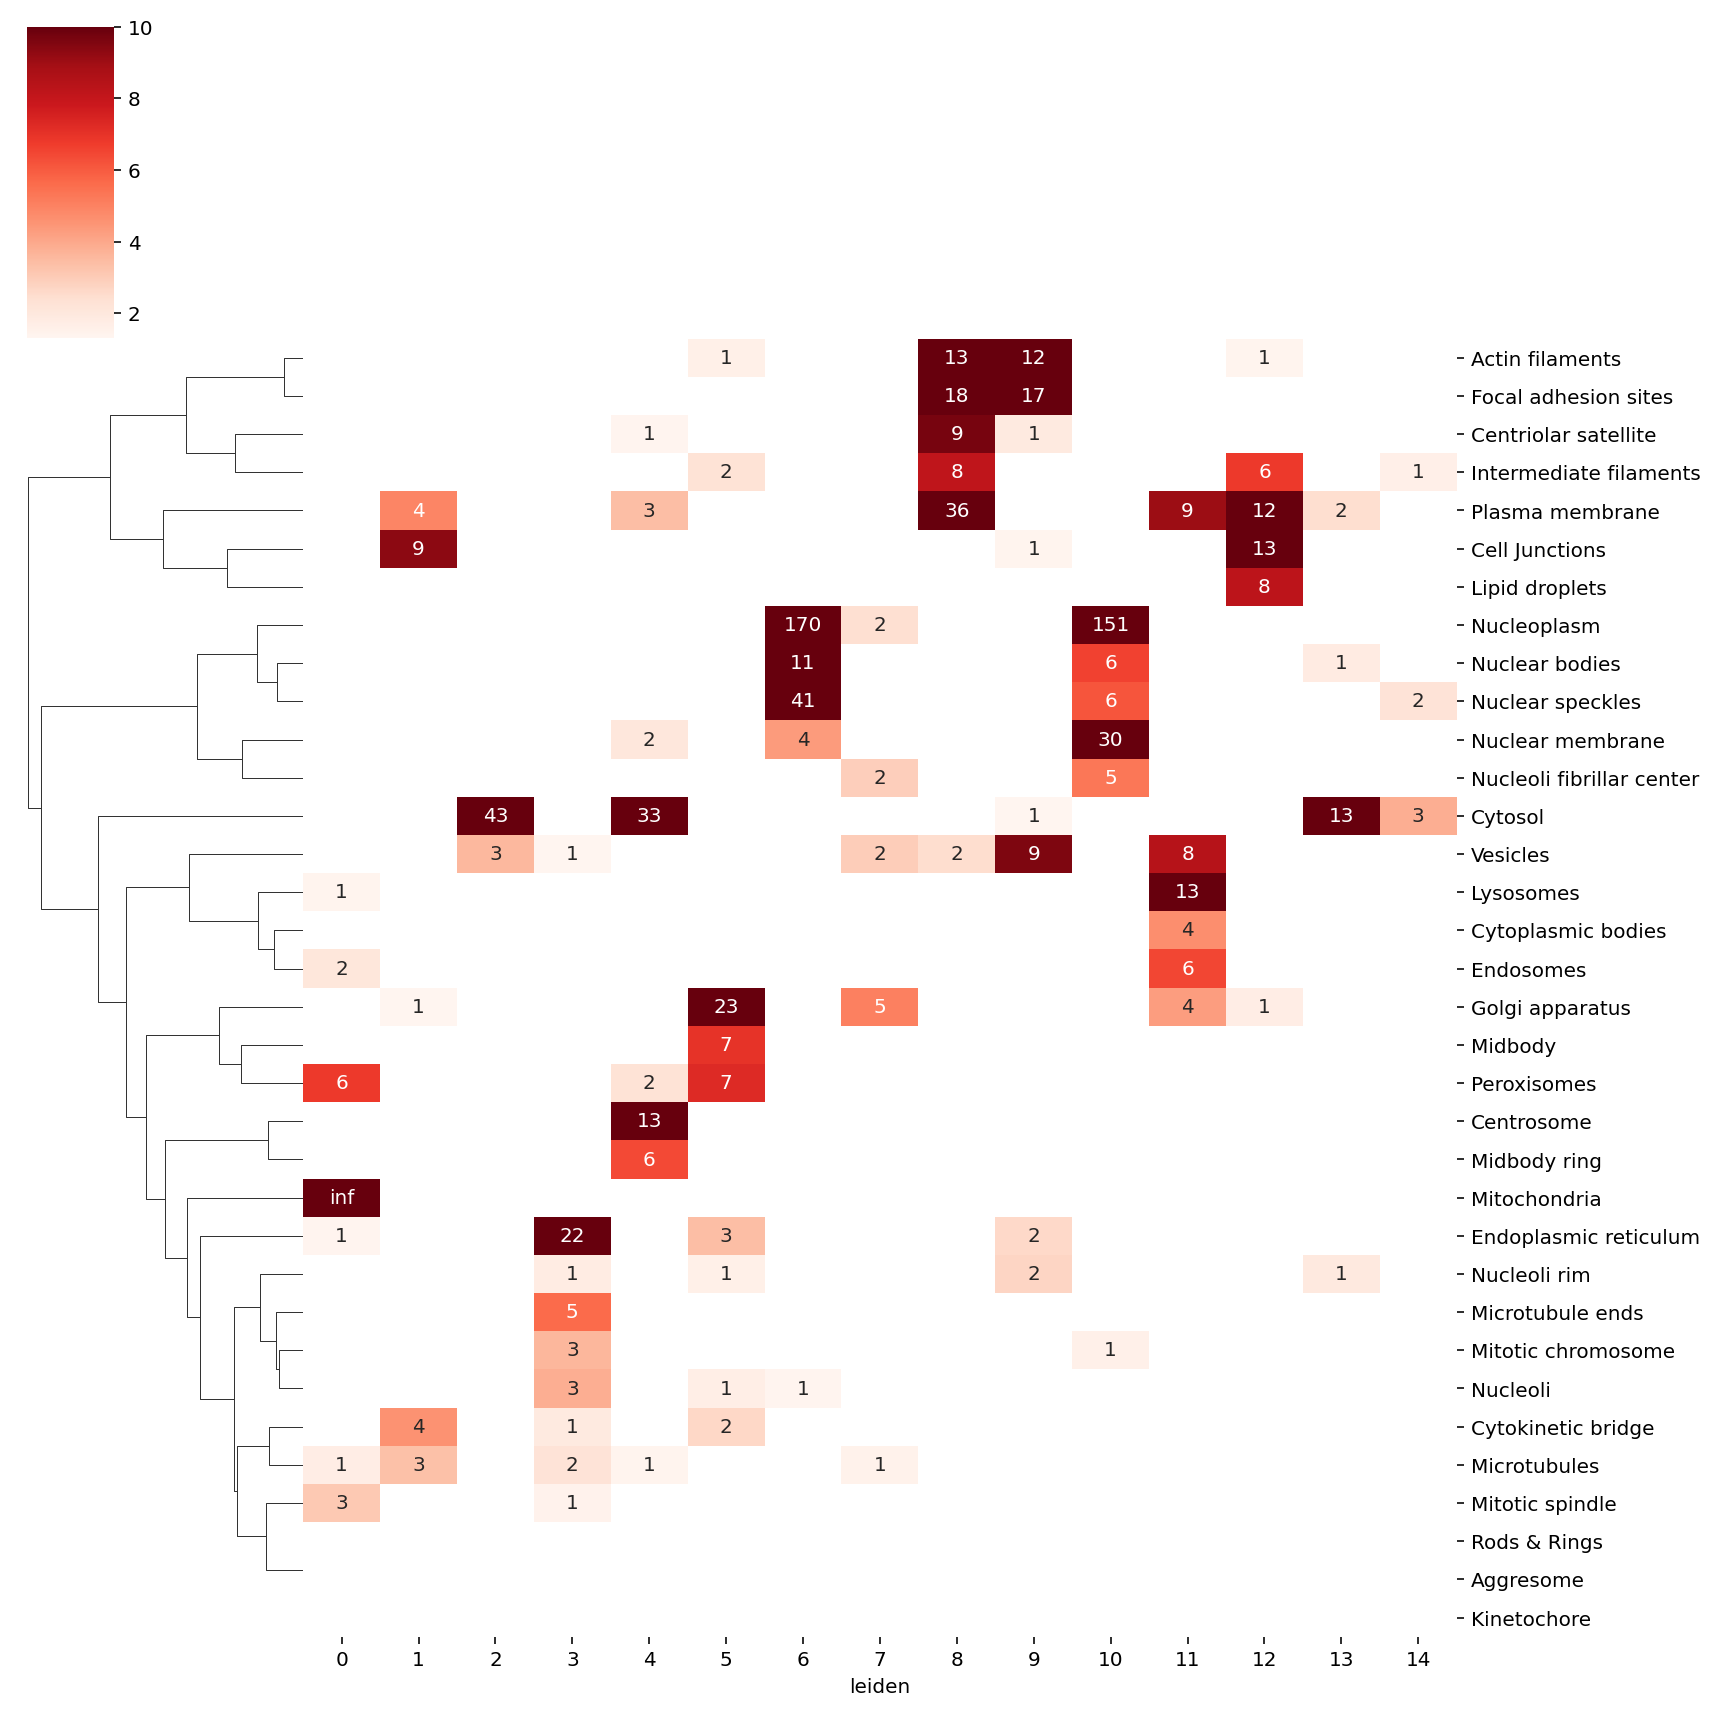

In [22]:
pvals = hgtest(adata_train.obs.groupby('leiden')[scl.columns].sum().astype(int))
x = (-np.log10(pvals)).T

sns.clustermap(x.clip(0,10),
               method='ward',
               col_cluster=False,
               cmap='Reds',
               mask=x<-np.log10(0.05),
               annot=np.floor(x),
               fmt='.0f',
               figsize=(12,12)
              )

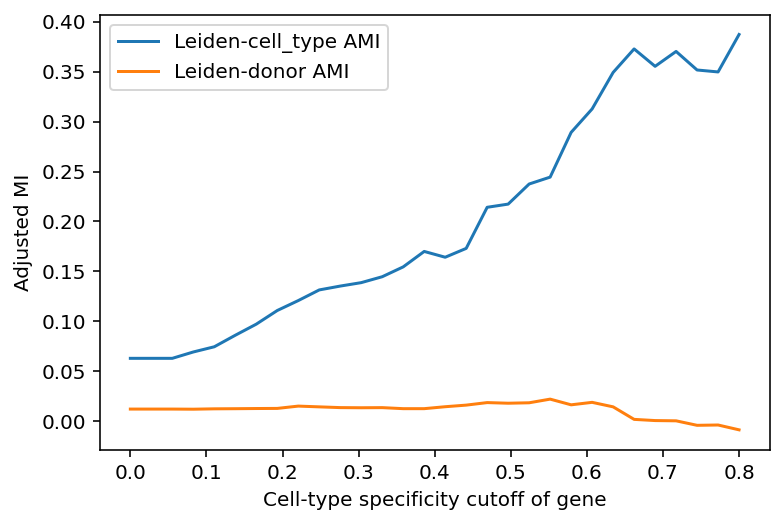

In [23]:
from sklearn.metrics import adjusted_mutual_info_score

amis = {}
for thr in np.linspace(0,0.8,30):
    amis[thr] = adjusted_mutual_info_score(
        adata_train.obs.query(f'specificity>{thr}')['leiden'], 
        adata_train.obs.query(f'specificity>{thr}')['cell_type']
    )
amis = pd.Series(amis)
plt.plot(amis,label='Leiden-cell_type AMI')

amis = {}
for thr in np.linspace(0,0.8,30):
    amis[thr] = adjusted_mutual_info_score(
        adata_train.obs.query(f'specificity>{thr}')['leiden'], 
        adata_train.obs.query(f'specificity>{thr}')['Patient']
    )
amis = pd.Series(amis)
plt.plot(amis,label='Leiden-donor AMI')


# ami_staining = adjusted_mutual_info_score(adata_train.obs['leiden'], adata_train.obs['Staining'])
# plt.plot([0,max(amis.index)],[ami_staining,]*2,label='Leiden-staining AMI')

plt.xlabel('Cell-type specificity cutoff of gene')
plt.ylabel('Adjusted MI')
# plt.xlim([0,0.9])
# plt.ylim([0,0.4])
plt.legend()

In [24]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler
from scipy.special import logsumexp, softmax, log_softmax, logit
from scipy.sparse import diags
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam

class SoftmaxRegression(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0, lr=0.01, max_iters=100, verbose=False, random_state=0):
        self.alpha = alpha
        self.max_iters = max_iters
        self.verbose = verbose
        self.coef_ = None
        self.intercept_ = None
        self.scaler_ = None
        self.lr = lr
        self.random_state = random_state
        
        self.model = None
        
    def fit(self, X, y, sample_weight=None):
        X = np.array(X)
        y = np.array(y)
        w = sample_weight
        
        self.scaler_ = StandardScaler()
        self.scaler_.fit(X)
        X = self.scaler_.transform(X)
        
        N, D = X.shape
        K = y.shape[1]
        self.classes_ = np.arange(K)
            
        torch.manual_seed(self.random_state)
            
        device = 'cuda'
        
        X = torch.tensor(X,dtype=torch.float32,device=device)
        Y = torch.tensor(y,dtype=torch.float32,device=device)
        
        self.model = nn.Linear(D,K).to(device=device)
        self.model.train()
        
        opt = Adam(self.model.parameters(),lr=self.lr)

        iterator = range(self.max_iters)
        if self.verbose:
            iterator = tqdm(iterator)
        for t in iterator:
            Y_hat = self.model(X)
            loss = F.cross_entropy(Y_hat, Y, reduction='sum') + self.alpha * self.model.weight.square().sum()
            loss.backward()
            opt.step()
            opt.zero_grad()

        self.model = self.model.cpu()
        self.model.requires_grad_(False)
        self.model.eval()
    
    def predict_proba(self, X):
        X = self.scaler_.transform(np.array(X))
        X = torch.tensor(X,dtype=torch.float32)
        Y_hat = self.model(X)
        Y_hat = Y_hat.cpu().numpy()
        Y_hat = softmax(Y_hat, axis=1)
        return Y_hat
                       
    def predict(self, X):
        Y_hat = self.predict_proba(X)
        Y_hat = np.argmax(Y_hat, axis=1)
        return Y_hat
    
    def score(self, X, y, sample_weight=None):
        X = self.scaler_.transform(np.array(X))
        
        X = torch.tensor(X,dtype=torch.float32)
        Y = torch.tensor(y,dtype=torch.float32)
        
        Y_hat = self.model(X)
        loss = F.cross_entropy(Y_hat, Y, reduction='sum').item()
        
        return loss

446


0.14385054911452697


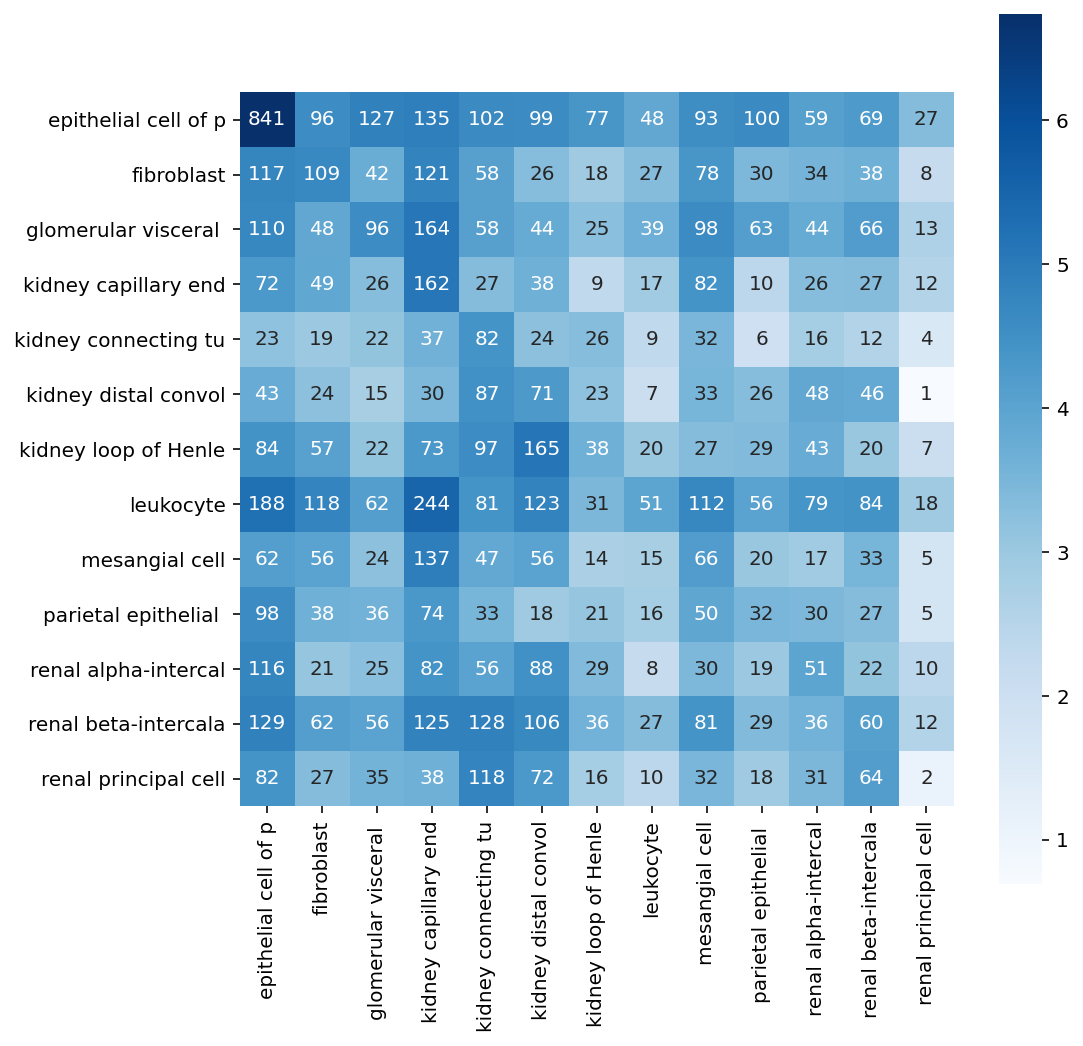

In [47]:
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score
from sklearn.svm import SVC
from scipy.special import softmax
from sklearn.model_selection import GroupKFold

train_idx = ~adata_train.obs[rna.columns].isna().any(axis=1)
print(adata_train.obs['Gene'].isin(set(hpa_markers.index)).sum())
train_idx &= ~adata_train.obs['Gene'].isin(set(hpa_markers.index)) # hold out the HPA markers
X_train = adata_train[train_idx].to_df()
Y_train = adata_train[train_idx].obs[rna.columns].copy()

# train_idx = ~adata_test.obs[rna.columns].isna().any(axis=1)
# train_idx &= ~adata_test.obs['Gene'].isin(set(hpa_markers.index)) # hold out the HPA markers
# X_train = adata_test[train_idx].to_df()
# Y_train = adata_test[train_idx].obs[rna.columns].copy()

X_test = adata_test.to_df()
Y_test = adata_test.obs[rna.columns].copy()

torch.manual_seed(0)
clf = SoftmaxRegression(max_iters=1000, lr=0.01, verbose=True)
# clf = SVC(kernel='rbf',C=1.0,probability=True)

labels_train = Y_train.idxmax(1)
w_train = (1./labels_train.value_counts())[labels_train]
groups_train = adata_train[train_idx].obs['Gene']

shape = Y_train.shape
columns = Y_train.columns
# Y_train = labels_train.copy()

npr.seed(0)
idx = npr.permutation(len(X_train)) # shuffle
Y_pred_train = np.zeros(shape)
Y_pred_train[idx] = cross_val_predict(
    clf,
    X_train.iloc[idx],
    Y_train.iloc[idx], 
    groups=groups_train.iloc[idx],
    method='predict_proba',
    cv=GroupKFold(n_splits=5)
)
Y_pred_train /= Y_pred_train.sum(1,keepdims=True)
Y_pred_train = pd.DataFrame(Y_pred_train,columns=columns,index=X_train.index)

labels_pred_train = Y_pred_train.idxmax(1)

clf.fit(X_train,Y_train)#,sample_weight=w_train)
Y_pred_test = clf.predict_proba(X_test)
# Y_pred_test = clf.predict(X_test)
Y_pred_test /= Y_pred_test.sum(1,keepdims=True)
Y_pred_test = pd.DataFrame(Y_pred_test,columns=columns,index=X_test.index)

print(balanced_accuracy_score(labels_train, labels_pred_train))

plt.figure(figsize=(8,8))
ls = [c[:20] for c in rna.columns]
conf_mtx = pd.DataFrame(confusion_matrix(labels_train,labels_pred_train),index=ls,columns=ls)

g = sns.heatmap(np.log(conf_mtx+1),square=True,annot=conf_mtx,cmap='Blues',fmt='d')

In [48]:
# in principel ***ALL*** of these should be present in the HPA!
region_labels = hpa_markers.reset_index().pivot(index=hpa_markers.index.name,columns='region')['gene']
region_labels = region_labels.fillna(0).astype(bool).astype(int)
region_labels

region                           collecting duct  distal tubule  glomerulus  \
Ensembl ID(supplied by Ensembl)                                               
ENSG00000004948                                0              0           0   
ENSG00000007216                                0              0           0   
ENSG00000008196                                0              1           0   
ENSG00000010932                                0              0           0   
ENSG00000015413                                0              0           0   
...                                          ...            ...         ...   
ENSG00000204653                                0              0           0   
ENSG00000214128                                1              0           0   
ENSG00000235961                                0              0           0   
ENSG00000243989                                0              0           0   
ENSG00000244067                                0              0           0   

region                           proximal tubule  
Ensembl ID(supplied by Ensembl)                   
ENSG00000004948                                1  
ENSG00000007216                                1  
ENSG00000008196                                0  
ENSG00000010932                                1  
ENSG00000015413                                1  
...                                          ...  
ENSG00000204653                                1  
ENSG00000214128                                0  
ENSG00000235961                                1  
ENSG00000243989                                1  
ENSG00000244067                                1  

[137 rows x 4 columns]

In [49]:
# one-vs-rest platt scaling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, KFold

def platt_scaling(scores, labels):
    lm = LogisticRegression(penalty='none')
    idx = list(set(scores.index)&set(labels.index))
    scores = {region:cross_val_predict(
        lm,
        scores.loc[idx],
        labels[region][idx],
        cv=KFold(5,shuffle=True,random_state=0),
        method='predict_proba'
    )[:,1] for region in labels.columns}
    scores = pd.DataFrame(
        scores,
        index=idx,
        columns=labels.columns
    )
    scores /= scores.sum(1).values[:,None]
    return scores

In [50]:
image_scores = Y_pred_test.join(df_test).groupby(['Antibody','Gene']).mean().groupby('Gene').mean()[rna.columns]
image_scores = image_scores.T.join(hpa_mapping).groupby('region').sum().T
image_scores = image_scores / image_scores.sum(1).values[:,None]
image_scores = image_scores.join(hpa_markers[[]],how='right')
# image_scores = image_scores.fillna(-np.inf)
image_scores = image_scores.dropna()
# image_scores = image_scores.rank(pct=True)
image_scores = platt_scaling(image_scores, region_labels)
image_scores

region           collecting duct  distal tubule  glomerulus  proximal tubule
ENSG00000235961     4.566668e-02   8.062096e-02    0.004219         0.869494
ENSG00000081479     1.425746e-03   2.885888e-04    0.004008         0.994278
ENSG00000136872     7.536496e-04   3.058441e-07    0.000054         0.999193
ENSG00000160202     1.925766e-02   9.077302e-02    0.566202         0.323767
ENSG00000056736     4.700086e-03   1.195406e-03    0.003154         0.990950
...                          ...            ...         ...              ...
ENSG00000137204     7.477367e-02   7.066764e-02    0.010827         0.843732
ENSG00000129151     1.990503e-03   5.948935e-08    0.000416         0.997593
ENSG00000144035     8.273289e-08   3.921054e-07    0.000479         0.999520
ENSG00000176974     5.761874e-03   2.418583e-05    0.000317         0.993897
ENSG00000143839     4.611624e-02   2.209517e-02    0.000014         0.931775

[128 rows x 4 columns]

In [51]:
rna_scores = sc.get.rank_genes_groups_df(rna_adata,group=None)
rna_scores = rna_scores.pivot(index='names',columns='group',values='scores')
rna_scores = rna_scores.T.join(hpa_mapping).groupby('region').max().T
rna_scores = rna_scores.join(hpa_markers[[]],how='right')
# rna_scores = rna_scores.fillna(-np.inf)
rna_scores = rna_scores.dropna()
# rna_scores = rna_scores.rank(pct=True)
rna_scores = platt_scaling(rna_scores, region_labels)
rna_scores

region           collecting duct  distal tubule  glomerulus  proximal tubule
ENSG00000235961     7.903389e-03       0.048552    0.219528         0.724016
ENSG00000081479     6.196165e-09       0.000010    0.259131         0.740859
ENSG00000136872     2.957826e-03       0.000280    0.019984         0.976778
ENSG00000160202     8.337517e-03       0.064798    0.053126         0.873738
ENSG00000056736     3.894583e-03       0.014118    0.032551         0.949436
...                          ...            ...         ...              ...
ENSG00000137204     1.488192e-02       0.002321    0.044572         0.938225
ENSG00000129151     1.494296e-05       0.001986    0.029637         0.968362
ENSG00000144035     7.424655e-03       0.022606    0.033793         0.936176
ENSG00000176974     9.705666e-04       0.002046    0.037720         0.959263
ENSG00000143839     2.134256e-04       0.047759    0.322974         0.629053

[137 rows x 4 columns]

In [52]:
# so i think this is fine... if something was dropped from the HPA, it's no longer valid!
region_labels = region_labels.loc[set(rna_scores.index) & set(image_scores.index)]
region_labels

region                           collecting duct  distal tubule  glomerulus  \
Ensembl ID(supplied by Ensembl)                                               
ENSG00000235961                                0              0           0   
ENSG00000081479                                0              0           0   
ENSG00000136872                                0              0           0   
ENSG00000160202                                0              0           0   
ENSG00000056736                                0              0           0   
...                                          ...            ...         ...   
ENSG00000137204                                0              0           0   
ENSG00000129151                                0              0           0   
ENSG00000144035                                0              0           0   
ENSG00000176974                                0              0           0   
ENSG00000143839                                0              0           0   

region                           proximal tubule  
Ensembl ID(supplied by Ensembl)                   
ENSG00000235961                                1  
ENSG00000081479                                1  
ENSG00000136872                                1  
ENSG00000160202                                1  
ENSG00000056736                                1  
...                                          ...  
ENSG00000137204                                1  
ENSG00000129151                                1  
ENSG00000144035                                1  
ENSG00000176974                                1  
ENSG00000143839                                1  

[128 rows x 4 columns]

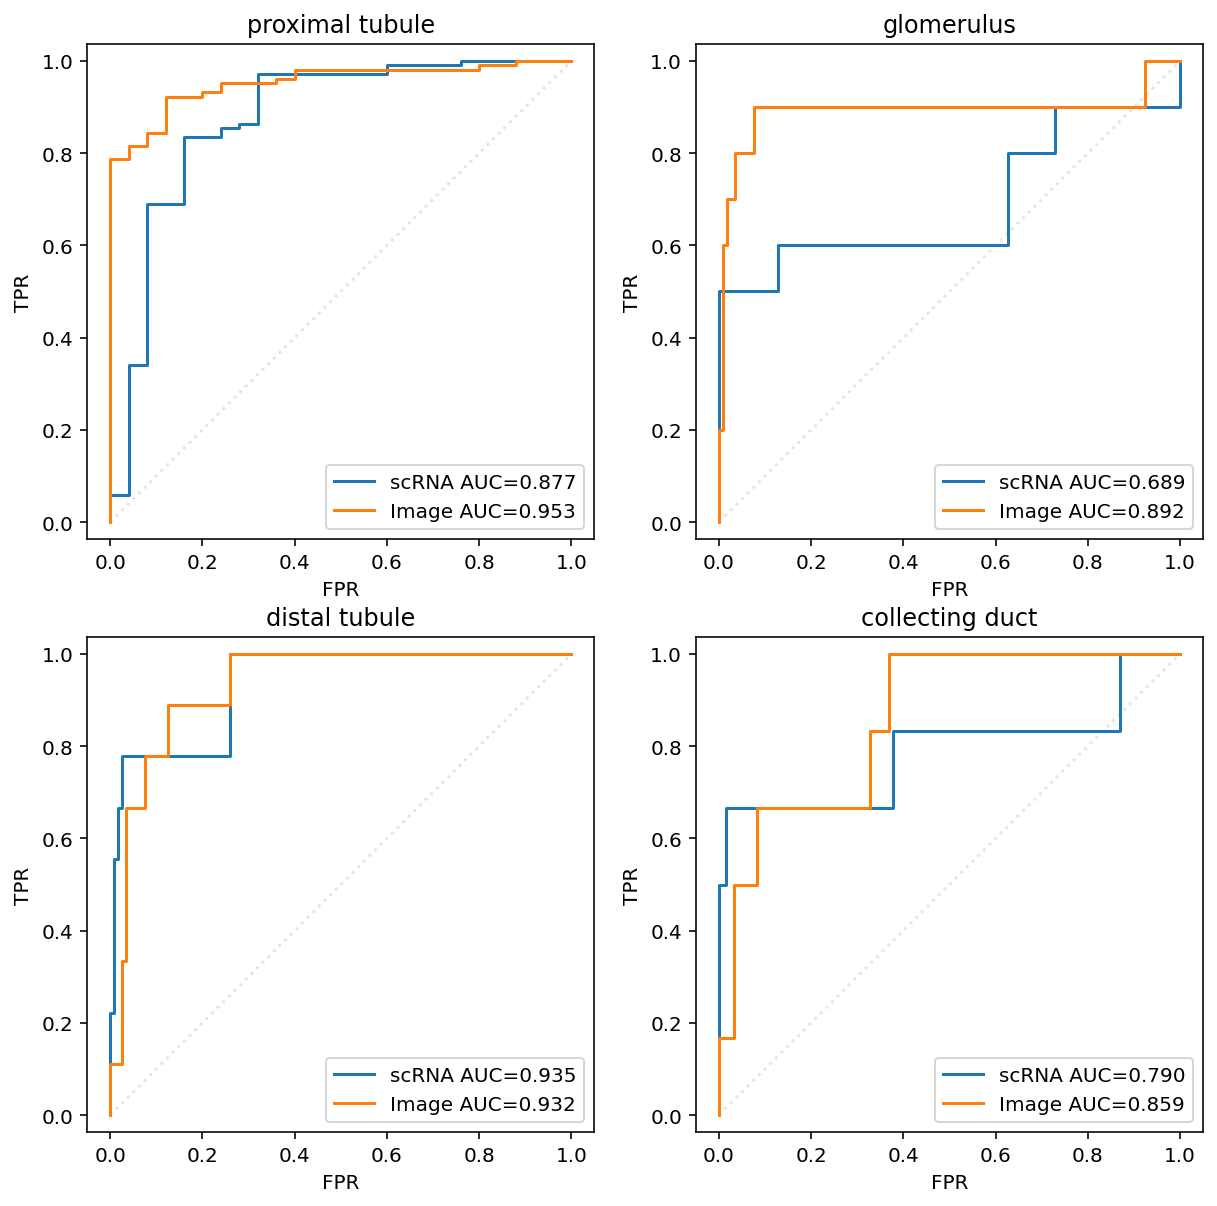

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score

regions = region_labels.sum().sort_values(ascending=False).index.tolist()

figsize = 5
fig,axs = plt.subplots(2,len(regions)//2,figsize=(len(regions)//2*figsize,2*figsize))
axs=axs.ravel()
for ax,region in zip(axs,regions):
    ax.plot([0,1],[0,1],'k:',alpha=0.1)
    ax.set_title(region)

    name = 'scRNA'
    y = region_labels[region]
    y_pred = rna_scores[region]
    idx = list(set(y.index)&set(y_pred.index))
    y, y_pred = y[idx], y_pred[idx]
    fpr, tpr, thr = roc_curve(y,y_pred)
    auc = roc_auc_score(y,y_pred)
    ax.plot(fpr,tpr,label=f'{name} AUC=%.3f'%auc)
    
    name = 'Image'
    y = region_labels[region]
    y_pred = image_scores[region]
    idx = list(set(y.index)&set(y_pred.index))
    y, y_pred = y[idx], y_pred[idx]
    fpr, tpr, thr = roc_curve(y,y_pred)
    auc = roc_auc_score(y,y_pred)
    ax.plot(fpr,tpr,label=f'{name} AUC=%.3f'%auc)
    
    ax.axis('equal')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend()

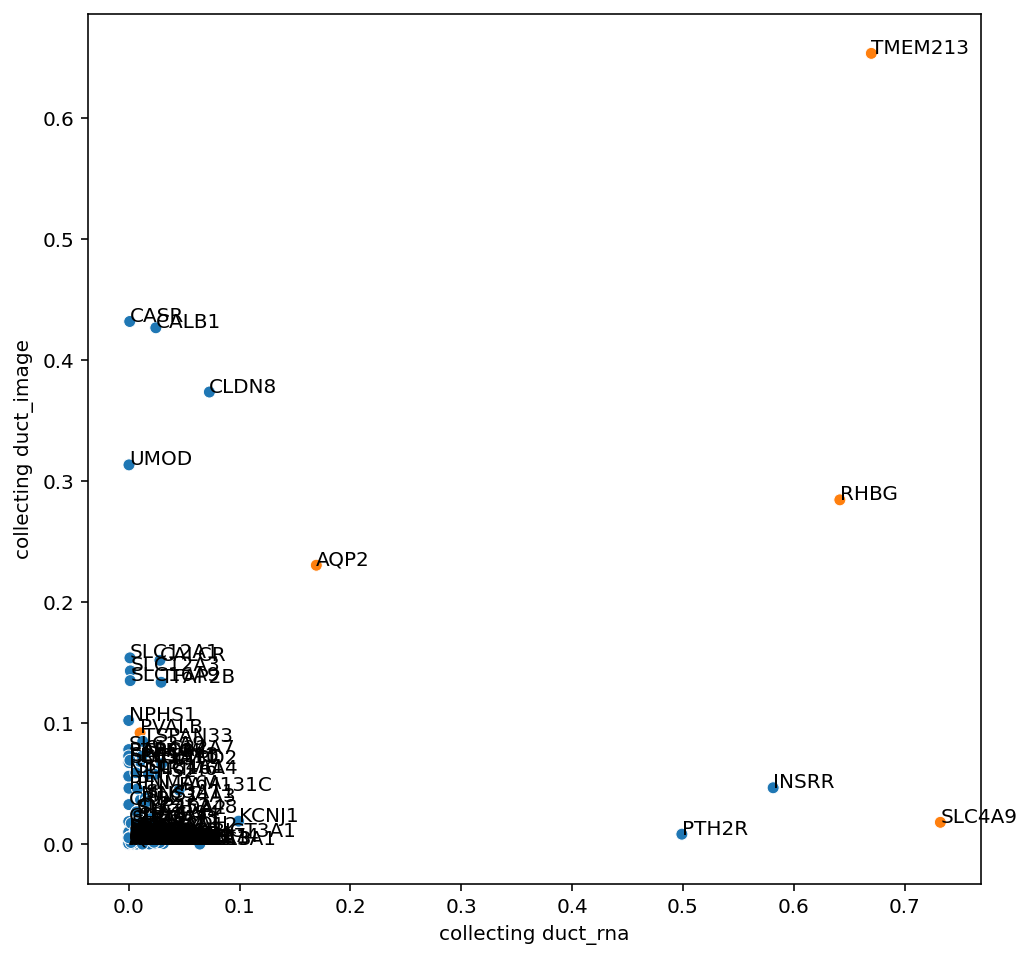

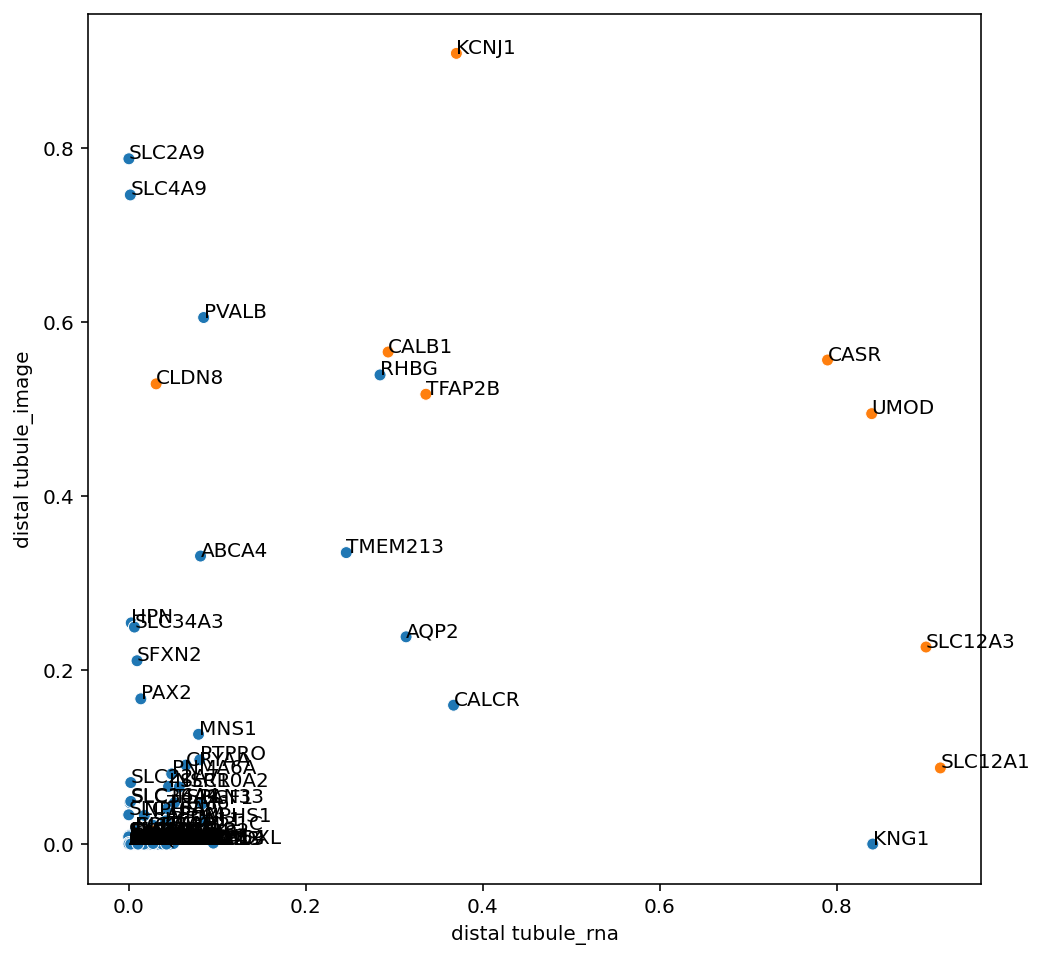

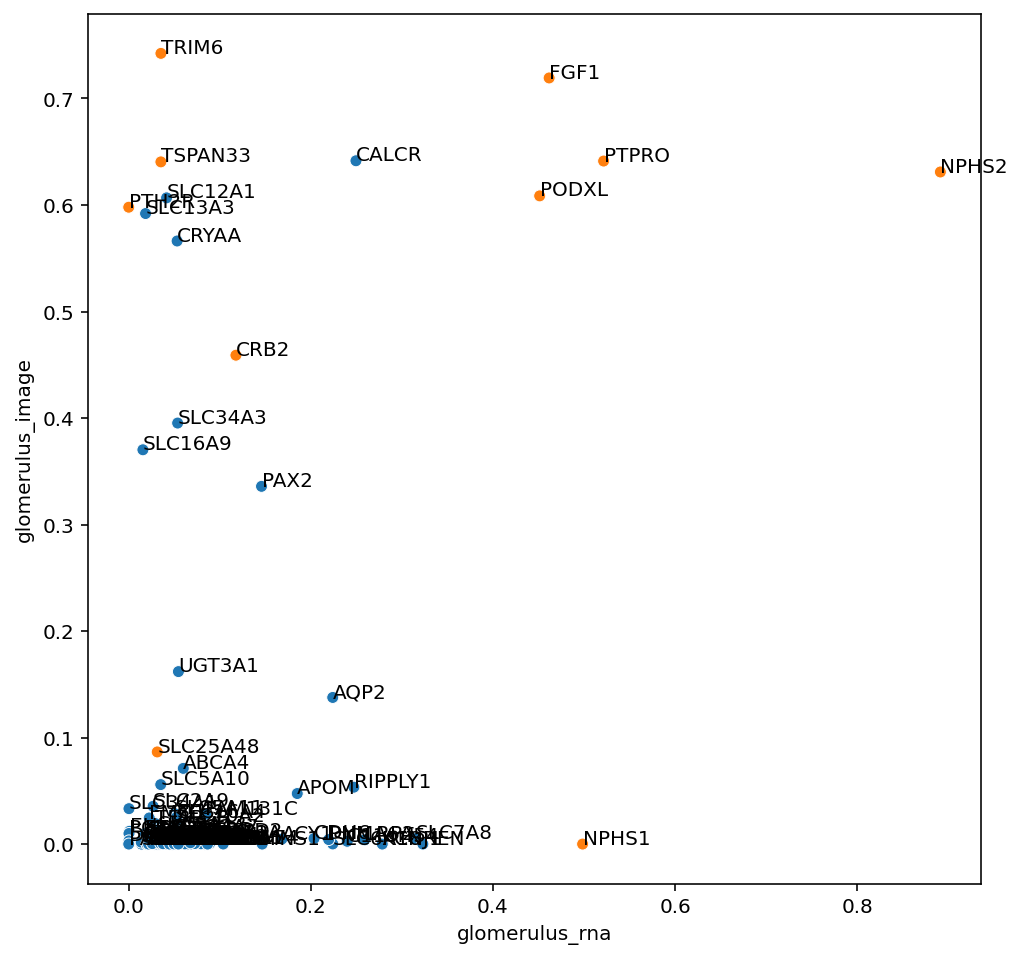

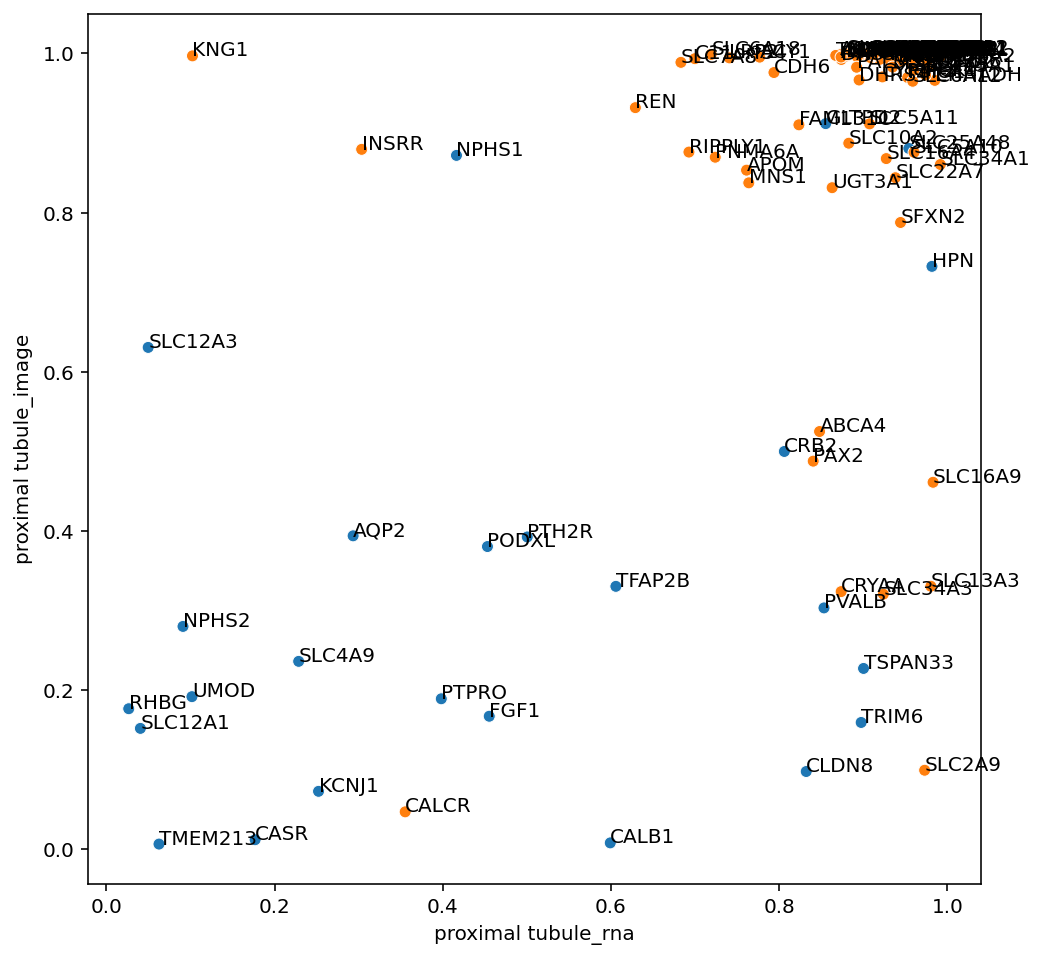

In [32]:
for region in region_labels.columns:
    plt.figure(figsize=(8,8))
#     data = image_scores.rank().join(rna_scores.rank(),how='outer',lsuffix='_image',rsuffix='_rna').join(region_labels,how='inner').fillna(0)
    data = image_scores.join(rna_scores,how='outer',lsuffix='_image',rsuffix='_rna').join(region_labels,how='inner').fillna(0)
    sns.scatterplot(
        data=data,
        x=region+'_rna',
        y=region+'_image',
        hue=region,
        legend=False
    )
    for t, (x, y, l) in data[[region+'_rna',region+'_image',region]].iterrows():
        plt.text(x,y,rna_var['feature_name'][t])

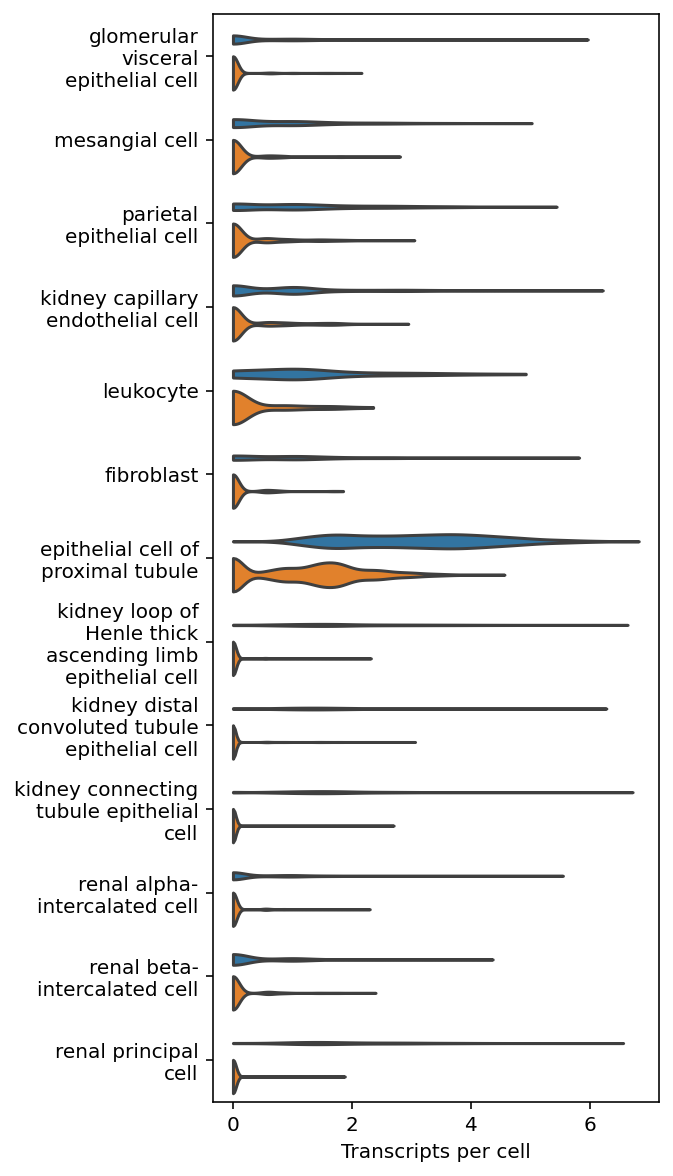

In [33]:
data = rna_adata[:,['ENSG00000144407','ENSG00000109667']].to_df()
data = data.melt(ignore_index=False)
data = data.join(rna_adata.obs['cell_type'])
plt.figure(figsize=(4,10))
sns.violinplot(
    data=data,
    y='cell_type',
    x='value',
    order=list(cell_type_colors),
    hue='variable',
    inner=None,
    cut=0,
)
import textwrap
plt.gca().set_yticklabels([textwrap.fill(e.get_text(), 18) for e in plt.gca().get_yticklabels()]);
plt.gca().set_xlabel('Transcripts per cell')
plt.gca().set_ylabel('')
plt.legend([],[], frameon=False)